This file contains python code to 
get the convergence curve for alpha under logi

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Get settings

In [60]:
from easydict import EasyDict as edict
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from copy import deepcopy
from scenarios.base_params import get_base_params

base_params = get_base_params("logi") 
base_params.data_gen_params = edict()
base_params.data_gen_params.d = 200 # num of ROIs
base_params.data_gen_params.q = 3 # num of other covariates
base_params.data_gen_params.npts = 100 # num of pts to evaluate X(s)
base_params.data_gen_params.types_ = ["int", "c", 2]
base_params.data_gen_params.gt_alp0 = np.array([-1, 2]) 
base_params.data_gen_params.data_params={"srho":0.3, "basis_type":"bsp"}
base_params.data_gen_params.intercept_cans = np.linspace(-30, 1, 20)
base_params.data_gen_params.data_type = base_params.model_type
base_params.can_Ns = [4, 6, 8, 10, 12, 14]
base_params.SIS_params = edict({"SIS_pen": 0.02, "SIS_basis_N":8, "SIS_ws":"simpson"})
base_params.opt_params.beta = 1 
base_params.can_lams = [0.60,  0.80,  1,  1.2, 1.4, 1.6, 2.0, 4.0]

def _get_gt_beta_wrapper(d, fct=2):
    def _get_gt_beta(cs):
        x = np.linspace(0, 1, 100)
        fourier_basis = fourier_basis_fn(x)
        fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                                     [np.zeros(50)] * (d-3-1) +
                                     [coef_fn(0.2)]
                                     )
        fourier_basis_coefs = np.array(fourier_basis_coefs).T 
        gt_beta = fourier_basis @ fourier_basis_coefs * fct
        return gt_beta
    return _get_gt_beta



setting = edict(deepcopy(base_params))
add_params = edict({})
add_params.data_gen_params = edict(deepcopy(base_params.data_gen_params))
add_params.data_gen_params.ns = [100, 200, 400, 800, 1600, 3200]
add_params.data_gen_params.cs = [0, 0, 0]
add_params.data_gen_params.npts = 100 # num of pts to evaluate X(s)
beta_fn = _get_gt_beta_wrapper(add_params.data_gen_params.d, fct=2)
add_params.data_gen_params.gt_beta = beta_fn(add_params.data_gen_params.cs)

add_params.setting = "alpcov"
add_params.sel_idx =  np.arange(0, add_params.data_gen_params.d)
add_params.SIS_ratio = 0.2
setting.update(add_params)

# Params

In [61]:
np.random.seed(0)

data_gen_params = setting.data_gen_params
x = np.linspace(0, 1, data_gen_params.npts)


num_rep = 200
save_dir = RES_ROOT/f"alp_test"
if not save_dir.exists():
    save_dir.mkdir()

In [62]:
# intercept is irrelevent to n
def _get_logi_int(data_gen_params, n_jobs=30, num_rep=100):
    ress = []
    for inte in tqdm(data_gen_params.intercept_cans):
        gt_alp = np.concatenate([[inte], data_gen_params.gt_alp0])
        def _run_fn(seed, data_gen_params=data_gen_params):
            data = gen_simu_sinica_dataset(
                    n=200, 
                    d=data_gen_params.d, 
                    q=data_gen_params.q, 
                    types_=data_gen_params.types_, 
                    gt_alp=gt_alp, 
                    gt_beta=data_gen_params.gt_beta, 
                    x = x,
                    data_type=data_gen_params.data_type, 
                    data_params=data_gen_params.data_params, 
                    seed=seed, 
                    verbose=1)
            return data.Y.numpy()
        with Parallel(n_jobs=n_jobs) as parallel:
            res = parallel(delayed(_run_fn)(seed) for seed in range(num_rep))
        ress.append(np.array(res))


    # get the intercept
    Yms = np.array([res.mean() for res in ress])
    intercept = data_gen_params.intercept_cans[np.argmin(np.abs(Yms-0.5))]
    print(f"The mean of Y is {Yms[np.argmin(np.abs(Yms-0.5))]:.3f} under intercept {intercept:.3f}.")
    gt_alp = np.concatenate([[intercept], data_gen_params.gt_alp0])
    return gt_alp

data_gen_params.gt_alp = np.array([0.535, -1, 2]) 
#data_gen_params.gt_alp = _get_logi_int(data_gen_params, 20);

# Simu

## Check data gen fn

In [14]:
data = gen_simu_sinica_dataset(
    n= 30,
    d=data_gen_params.d, 
    q=data_gen_params.q, 
    types_=data_gen_params.types_, 
    gt_alp=data_gen_params.gt_alp, 
    gt_beta=data_gen_params.gt_beta, 
    x=x,
    data_type=data_gen_params.data_type,
    data_params=data_gen_params.data_params, 
    seed=1, 
    verbose=2);

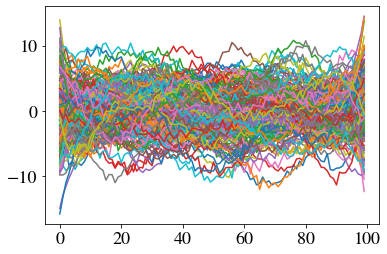

In [17]:
sub_ix = 1
X = data.X

for beta_ix in range(X.shape[1]):
    plt.plot(X[sub_ix, beta_ix])



## SIS check (just for check)

In [18]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, setting):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    data_gen_params = edict(setting.data_gen_params.copy())
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    cur_data = gen_simu_sinica_dataset(n=data_gen_params.ns[0], 
                                   d=data_gen_params.d, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   x=x, 
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=2);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, ws=setting.SIS_params.SIS_ws,
                             basis_mat=basis_mat, keep_ratio=SIS_ratio, 
                             model_type=setting.model_type, SIS_pen=SIS_pen, sel_idx=setting.sel_idx)
    M_idxs = np.delete(np.arange(data_gen_params.d), setting.sel_idx)
    keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return keep_idxs

In [19]:
obt_bsp = obt_bsp_obasis_Rfn
num_rep = 100
with Parallel(n_jobs=30) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.05, N=8, SIS_pen=0.02, setting=setting) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))

  0%|                                                                                    | 0/100 [00:00<?, ?it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The follo

Text(0.5, 1.0, '[0.04 0.03 0.04 0.06 0.04 0.02 0.11 0.04 1.  ]')

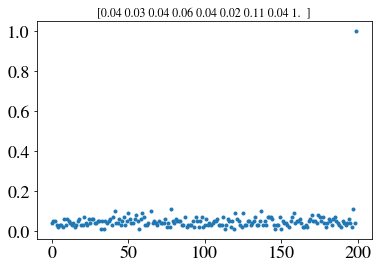

In [20]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 190]}")

## Simulation

In [63]:
def _run_fn(seed, n, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    x = np.linspace(0, 1, data_gen_params.npts)
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_sinica_dataset(n=n, 
                                   d=data_gen_params.d, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   x=x,
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=verbose);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


In [64]:
def get_ci(est_alp, cov_mat, alp_idx):
    ci_lim = 1.96*cov_mat[alp_idx, alp_idx].sqrt().item()
    ci = [est_alp[alp_idx].item()-ci_lim,  est_alp[alp_idx].item()+ci_lim]
    return ci
def get_alp_cov(hdf_fit):
    Q_mat = hdf_fit.hypo_utils.Q_mat_part
    Q_mat_inv = torch.linalg.pinv(Q_mat, hermitian=True, rtol=1e-7)
    Sig_mat = hdf_fit.hypo_utils.Sig_mat_part
    Cov_mat = Q_mat_inv @ Sig_mat @  Q_mat_inv / hdf_fit.data_params.n
    return Cov_mat[:hdf_fit.data_params.q,:hdf_fit.data_params.q];

### single test

In [68]:
seed = 0 
lam = 0.15
N = 4

setting.opt_params.N_maxit = 100
setting.opt_params.N_eps = 1e-4
setting.opt_params.stop_cv = 5e-4
setting.opt_params.beta = 1
setting.opt_params.one_step_verbose = 0
setting.opt_params.is_BFGS = False
res = _run_fn(n=400, seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)

2024-03-01 11:05:03,404 - optimization.opt - INFO - opt params is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1, 'R': 200000.0, 'N_eps': 0.0001, 'N_maxit': 100, 'is_BFGS': False}.
2024-03-01 11:05:03,405 - optimization.opt - INFO - SIS params is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2, 'SIS_ws': 'simpson'}.
2024-03-01 11:05:03,406 - optimization.opt - INFO - model params is {'ws': 'simpson'}.
2024-03-01 11:05:03,406 - optimization.opt - INFO - penalty params is {'a': 3.7, 'lam': 0.15}.
2024-03-01 11:05:03,407 - optimization.opt - INFO - bspline params is {'basis_ord': 4, 'is_orth_basis': True, 'N': 4}.
2024-03-01 11:05:03,408 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:   1%|▌                                                                                         | 13/2000 [00:00<01:28, 22.50it/s, error=0.00119, GamL0=3, CV=0.0005]


In [68]:
res.est_alp

tensor([ 0.4347, -0.4963,  0.3523])

In [30]:
res._prepare_hypotest()

In [31]:
cov_mat = get_alp_cov(res)
est_alp = res.est_alp
for alp_idx in range(1, data_gen_params.q):
    ci = get_ci(est_alp, cov_mat, alp_idx=alp_idx)
    print(ci)

[-3.5675953910403795, -0.5922779683268888]
[-0.31191685763751864, 3.0597707667290974]


### Multipe test

In [34]:
seed = 6
N = 8
lam = 4

setting.opt_params.N_maxit = 100
setting.opt_params.N_eps = 1e-6
setting.opt_params.stop_cv = 5e-4
setting.opt_params.beta = 1
setting.opt_params.one_step_verbose = 0
setting.opt_params.is_BFGS = False

def _run_fn1(seed, n=100):
    res = _run_fn(seed=seed, n=n, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res._prepare_hypotest()
    test_res = edict()
    test_res.est_alp = res.est_alp
    test_res.cov_mat = get_alp_cov(res)
    return test_res
    
num_rep = 60
    

60

In [35]:
gt_alp = data_gen_params.gt_alp;
ns = data_gen_params.ns
ns = [400]

ci_lens = np.zeros((len(ns), len(gt_alp)-1))
cov_probs = np.zeros((len(ns), len(gt_alp)-1))
for n in ns:
    with Parallel(n_jobs=20) as parallel:
        ress = parallel(delayed(_run_fn1)(seed, n=n) for seed in tqdm(range(num_rep), total=num_rep, desc=f"n: {n}"))
    for alp_idx in range(1, data_gen_params.q):
        cis = np.array([get_ci(res.est_alp, res.cov_mat, alp_idx=alp_idx) for res in ress]);
        cov_prob = np.bitwise_and(cis[:, 0] < gt_alp[alp_idx], cis[:, 1] > gt_alp[alp_idx]).mean()
        ci_len = np.diff(cis, axis=1).mean()
        
        cov_probs[ns.index(n), alp_idx-1] = cov_prob
        ci_lens[ns.index(n), alp_idx-1] = ci_len

n: 400:  33%|███████████████████████████████████████████▎                                                                                      | 20/60 [00:00<00:01, 38.24it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching pac

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/tmp/ipykernel_18588/3951061643.py", line 13, in _run_fn1
  File "/tmp/ipykernel_18588/3166090289.py", line 21, in _run_fn
  File "/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/hdf_utils/data_gen.py", line 413, in gen_simu_sinica_dataset
    simu_curvs0 = simu_curvs0 + errsX
  File "/opt/conda/lib/python3.9/site-packages/rpy2/rinterface.py", line 94, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/

In [111]:
cov_probs

array([[0.53333333, 0.48333333]])

1.326774923937027